# TODO
1. PairPlots
2. Profiling reports
3. Compare results to preprocessed of UCI

In [121]:
generate_profiling_reports = False

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [123]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [124]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = re.sub("[a-zA-Z]+ ","name\n", dataString)
        dataString = dataString.replace(" ",",")
        return dataString

In [125]:
# read the data from the specified datasets into the df
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [126]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [127]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

In [128]:
df = df.replace(-9, float('nan'))

In [129]:
import pandas_profiling

if generate_profiling_reports:
    profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report for the complete UCI dataset', explorative=True)
    profile.to_file("Pandas Profiling Report for all features.html")

# Through the high correlation check if dummy is equal to trestbps

In [130]:
print(df[df['dummy'] == df['trestbps']].shape)

(840, 77)


It is assumed that these two variables are representing the same value. Dummy is therefor removed.

In [131]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name", # Constant

]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [132]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    'junk', # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy" # same as trestbps
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [133]:
hidden_identifier = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(hidden_identifier, inplace=True, axis=1)

In [134]:
if generate_profiling_reports:
    profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report for the used features from the UCI dataset', explorative=True)
    profile.to_file("Pandas Profiling Report for all used features.html")

# Start of analysis
## Static Analysis
### Get the number of entries where the ST Depression was measured at a timepoint that is higher than the Exercise electrocardiogram

In [135]:
df[df['thaltime'] > df['thaldur']].shape

(25, 45)

### Analyse thalach and thalrest

In [136]:
df.loc[df['thalach'] < df['thalrest'],['thalach','thalrest']]

,thalach,thalrest
673,60.0,63.0


The resting heart rate (thalrest) can not be lower than the maximum archived heart rate (thalach) because the thalach seems unrealisitc it is set to NaN

## see effects of enriching smoke

In [137]:
#enrich smoke
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
percentage_missing_pre = ((df["smoke"].isna().sum() / len(df) * 100).round(2))

dfst = DataframeSmokeTransformer()
df = dfst.transform(df)

percentage_missing_post = ((df["smoke"].isna().sum() / len(df) * 100).round(2))
print(f"missing before enrichment:\t {percentage_missing_pre}%")
print(f"missing after enrichment:\t {percentage_missing_post}%")

missing before enrichment:	 74.42%
missing after enrichment:	 43.05%


## Explore how many NaNs and zeros are within one column for each attribute.

In [138]:
(df.loc[:, df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,91,0,0,0,0,0,108,0,115,115,115,240,0,107,138,271,186,211,252,248,0,0,43,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,157,0
hungarian,0,81,23,164,141,0,0,195,0,10,0,0,266,0,1,235,293,274,265,269,290,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,3,0,2,0,188,0
long-beach-va,0,6,15,65,33,0,1,90,49,96,38,38,125,4,100,80,122,88,61,105,94,0,0,2,0,0,0,0,0,1,52,139,40,1,0,0,2,0,10,0,2,0,51,0
switzerland,0,10,11,22,27,0,0,60,123,5,0,0,43,0,0,85,116,70,75,66,93,0,0,25,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,8,0


In [139]:
(df.loc[:, df.columns != 'dataset'].eq(-9)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
switzerland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## outliers

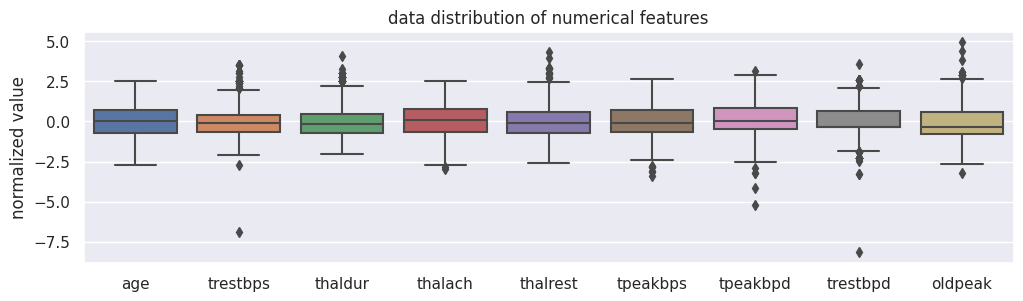

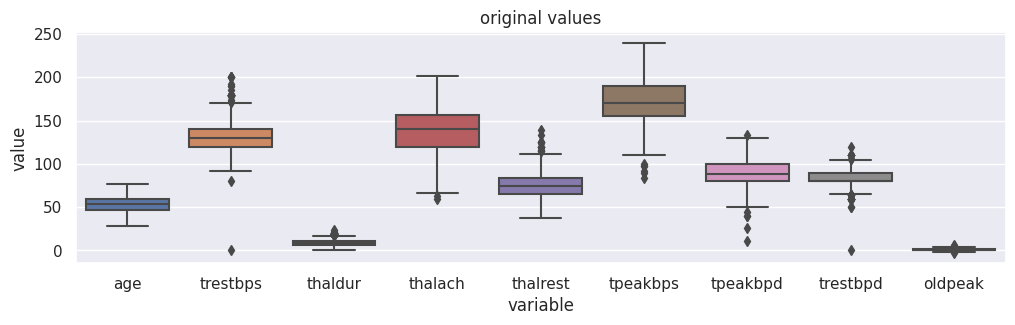

In [140]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]

sc = StandardScaler()
temp = sc.fit_transform(df_continous)
df_continous = pd.DataFrame(temp, columns = ["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"])
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
ax.set(xlabel='', ylabel='normalized value')
plt.title("data distribution of numerical features")
plt.show()

df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]

sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("original values")
sns.set(rc={"figure.figsize":(12, 3)})
plt.show()




## Correlation

In [141]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
test = {}
for percentage in np.arange(0,100,1):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).shape + (df.drop([*missing_vlaues.keys()], axis=1).isna().sum().sum(), )

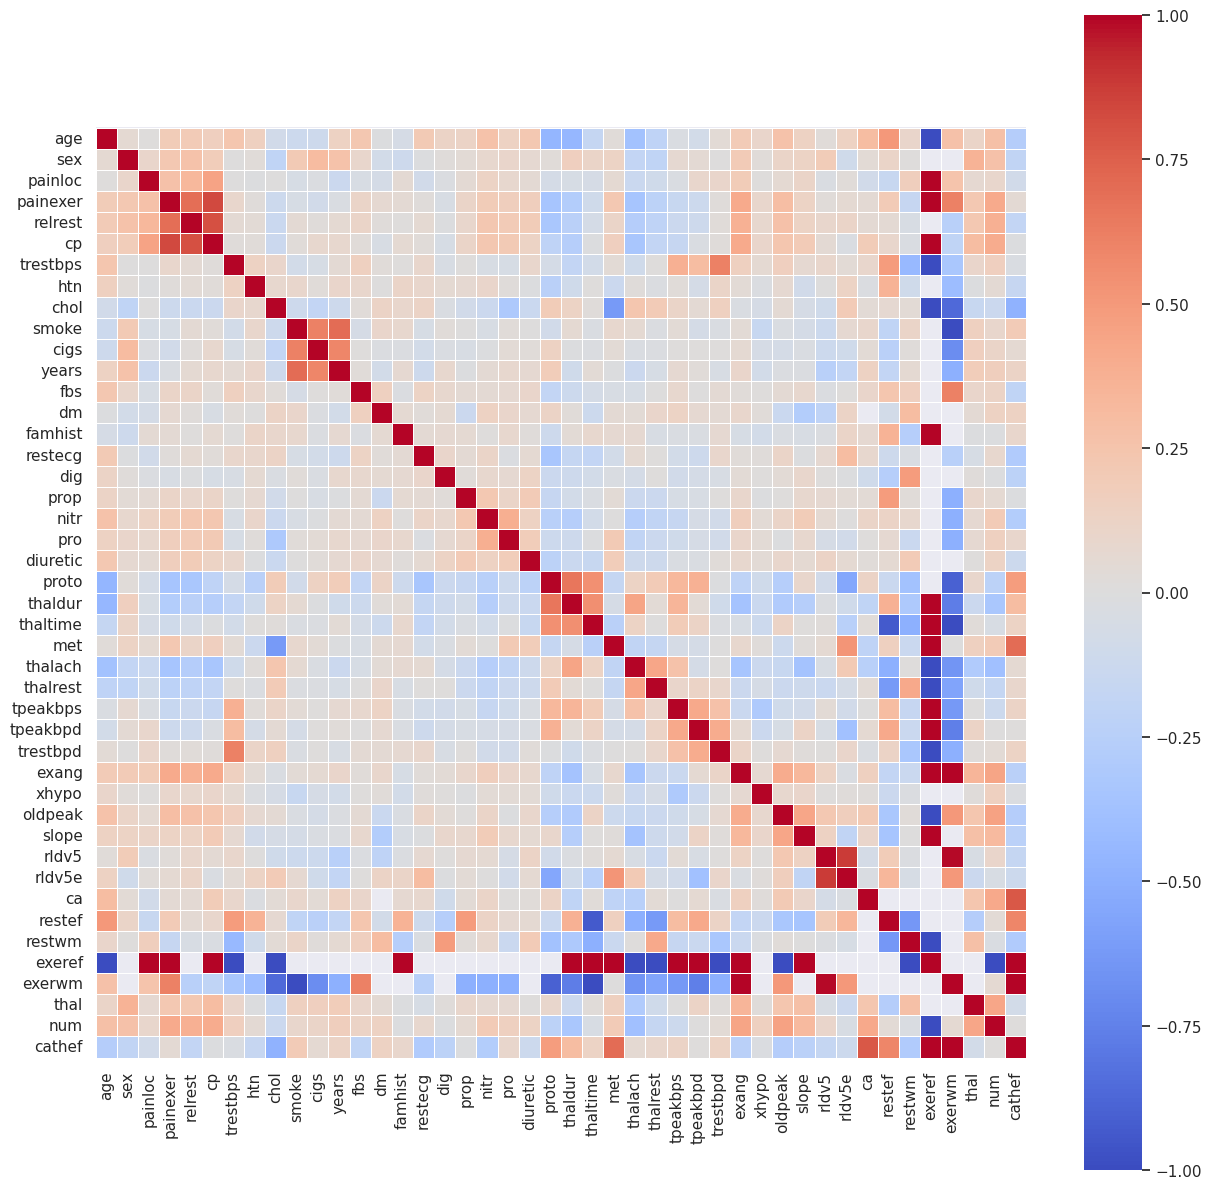

In [142]:
plt.figure(figsize=(15,15))
# Compute the correlation matrix
corr = df.corr()
corr = corr.round(2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

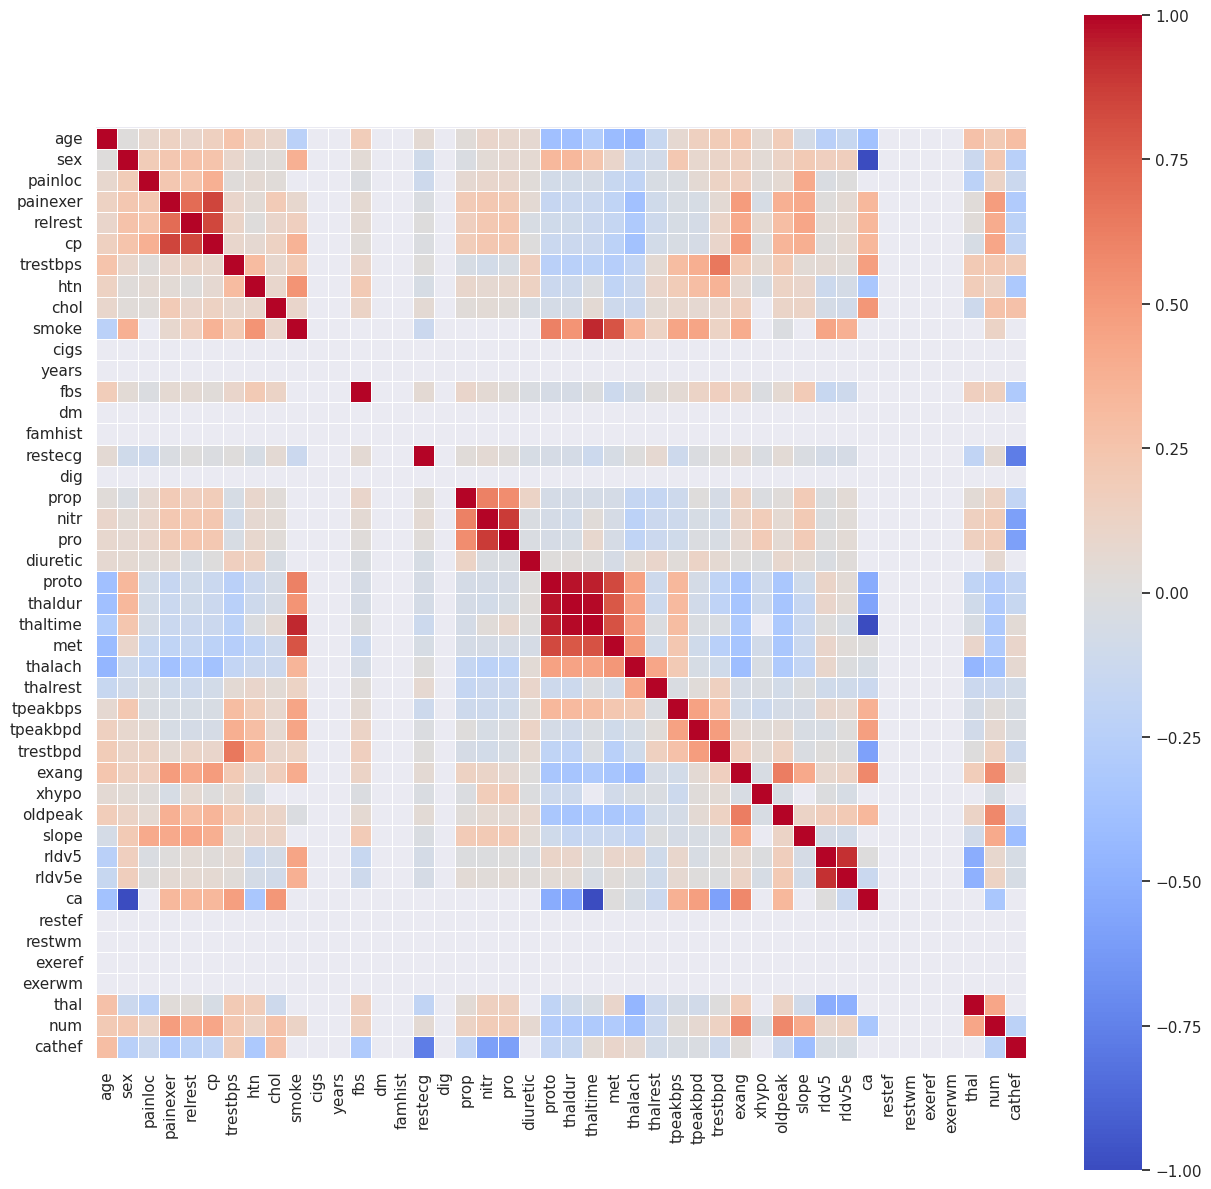

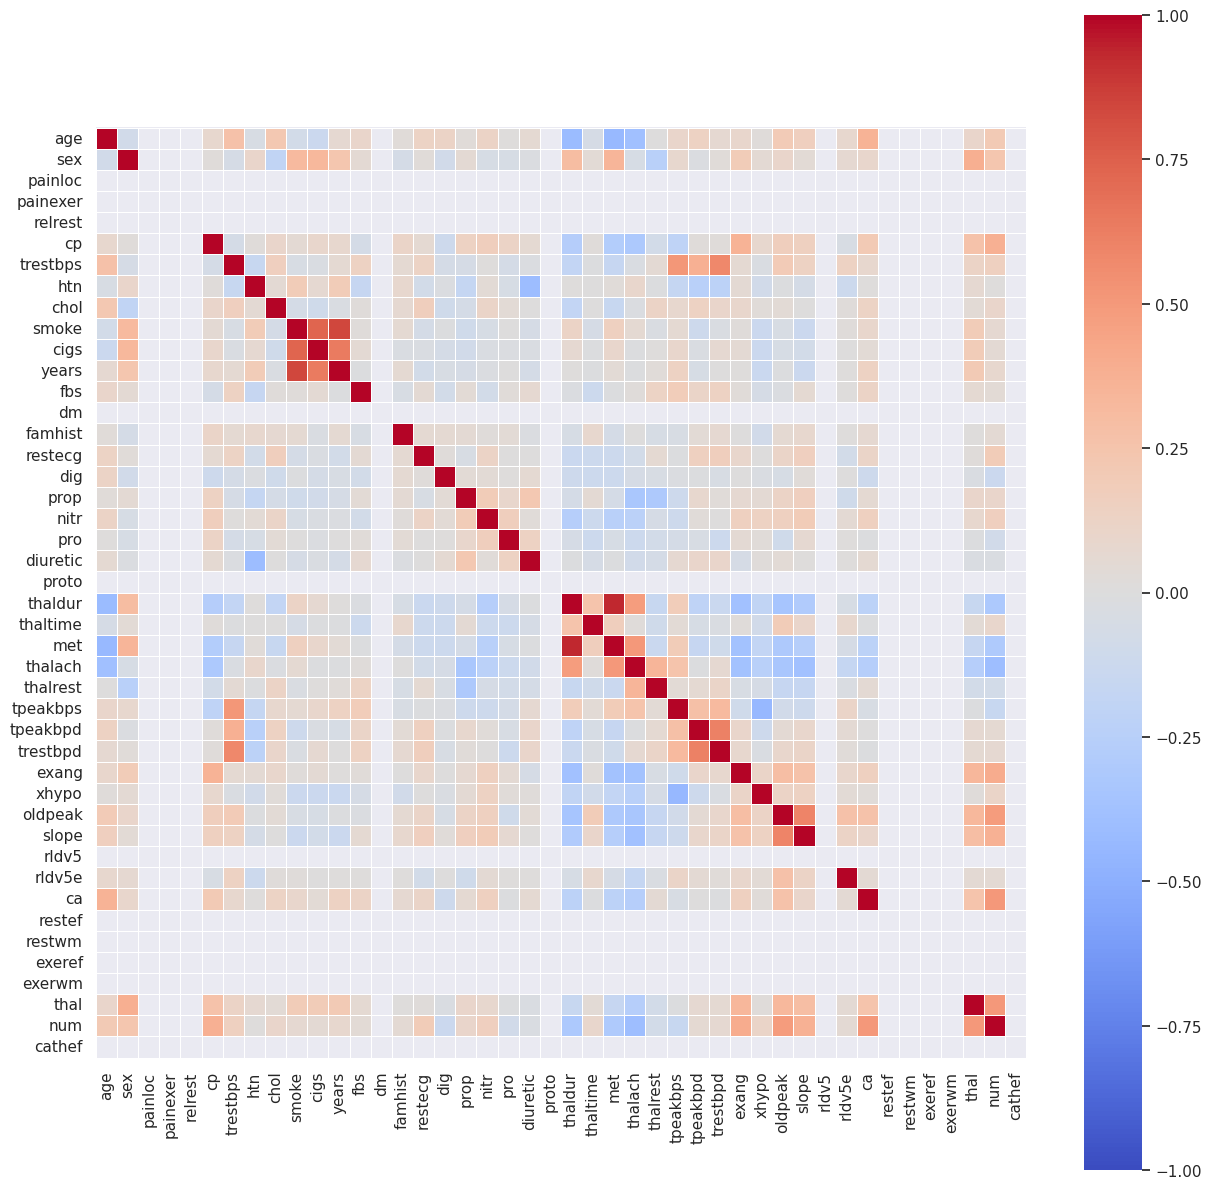

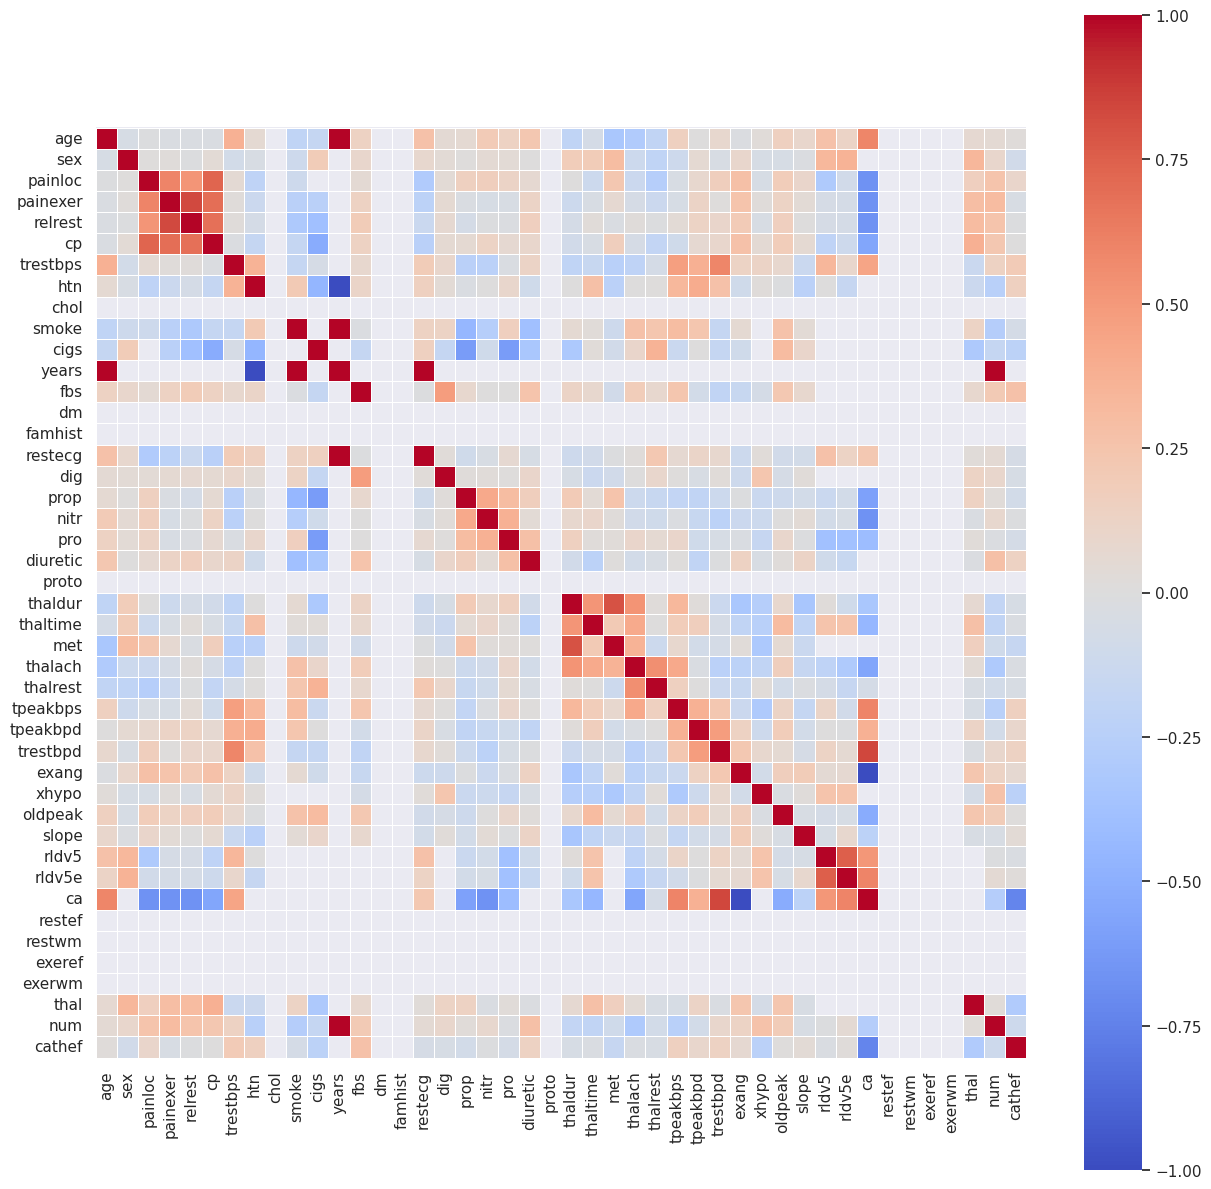

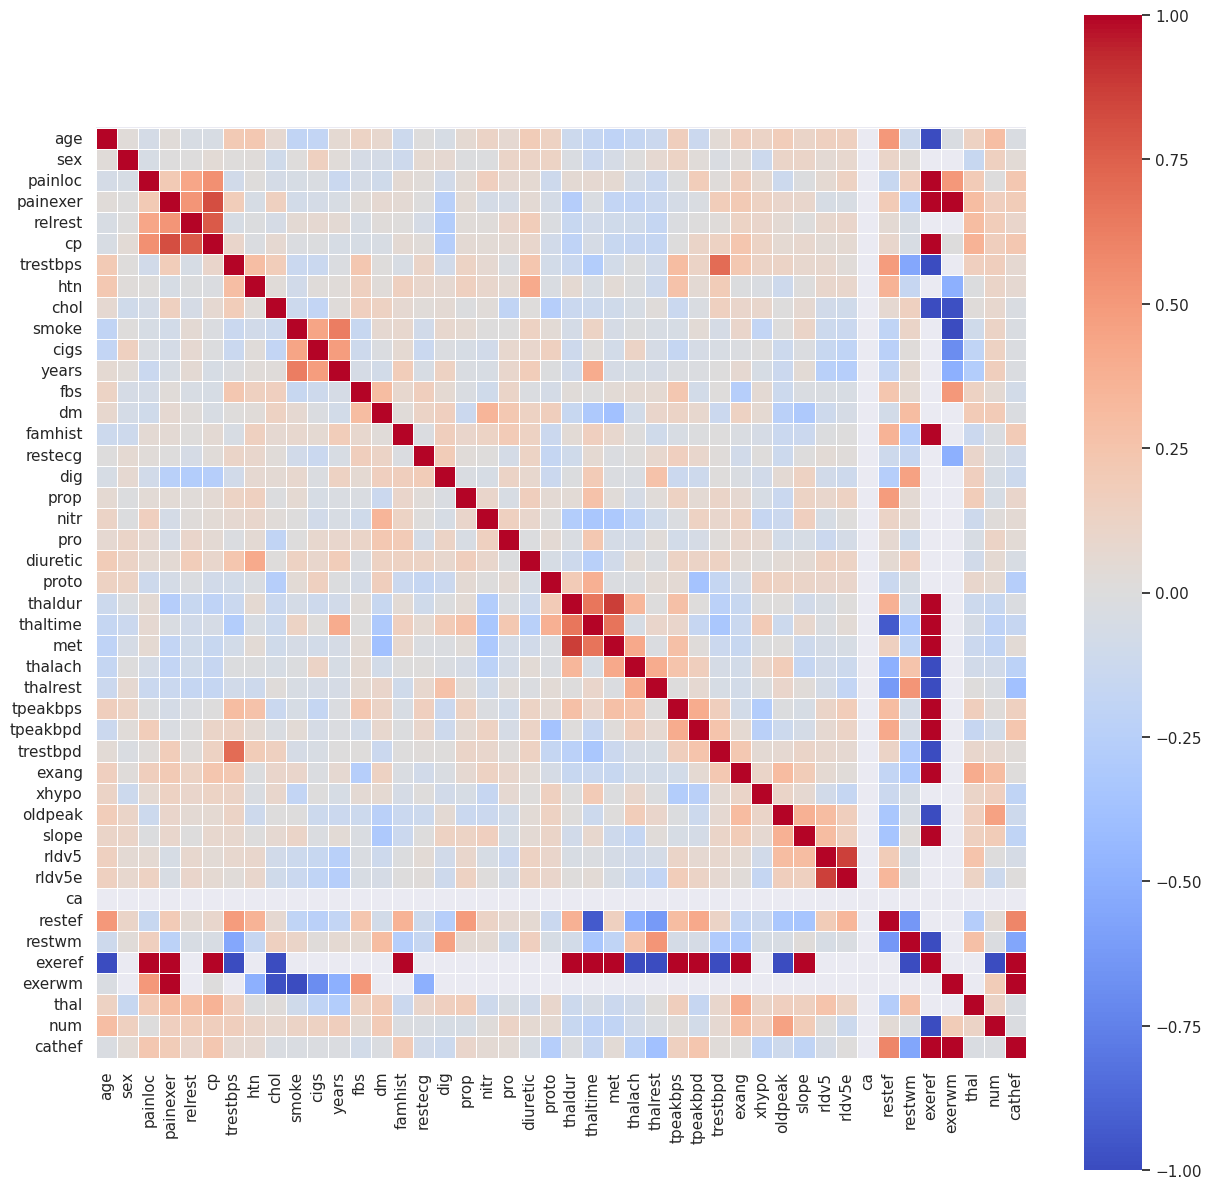

In [143]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    # Compute the correlation matrix
    corr = df[df['dataset'] == dataset].corr()
    corr = corr.round(2)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
    plt.show()


In [144]:
df_corr = df.copy()
df_corr = pd.concat([df_corr,pd.get_dummies(df_corr['cp'], prefix='cp')],axis=1)
df_corr.drop(['cp'],axis=1, inplace=True)

percentage_missing = ((df_corr.isna().sum()/len(df_corr)*100).round(2)).to_dict()

In [145]:
unstacked_corr = df_corr.corr().unstack()
#remove duplicate pairs
#index = pd.MultiIndex.from_tuples(tuples)
unstacked_corr = unstacked_corr.reset_index()
unstacked_corr.columns = ["feature1","feature2","correlation"]
#remove duplicates and correlation between the same feature
unstacked_corr = unstacked_corr[unstacked_corr['feature1'] < unstacked_corr['feature2']]
unstacked_corr['NaN_Values_feature1'] = [percentage_missing[x] for x in unstacked_corr['feature1']]
unstacked_corr['NaN_Values_feature2'] = [percentage_missing[x] for x in unstacked_corr['feature2']]
unstacked_corr['abs_corr'] = abs(unstacked_corr['correlation'])
unstacked_corr = unstacked_corr[(abs(unstacked_corr["correlation"]) > 0.5) & (unstacked_corr['NaN_Values_feature1'] < 75) & (unstacked_corr['NaN_Values_feature2'] < 75)].sort_values(by="abs_corr", ascending=False)
unstacked_corr.drop(["abs_corr"], inplace=True, axis=1)
print(unstacked_corr)

      feature1  feature2  correlation  NaN_Values_feature1  \
2165      cp_4  painexer     0.927771                 0.00   
1585     rldv5    rldv5e     0.884520                47.27   
1687        ca    cathef     0.784472                67.63   
2166      cp_4   relrest     0.719787                 0.00   
2072      cp_2   relrest    -0.712302                 0.00   
386      smoke     years     0.704192                43.05   
1997    cathef       met     0.696134                65.41   
145   painexer   relrest     0.694375                31.37   
961      proto   thaldur     0.663422                12.46   
2023      cp_1   painloc    -0.638315                 0.00   
352       chol       met    -0.619028                 3.34   
1321  trestbpd  trestbps     0.614386                 6.56   
431       cigs     smoke     0.610471                46.72   
433       cigs     years     0.589092                46.72   
2161      cp_3      cp_4    -0.582680                 0.00   
1009   t

In [146]:
cp_4VSpainexer = pd.crosstab(df_corr['cp_4'], df_corr['painexer'], rownames=['cp_4'], colnames=['painexer'])
cpVSpainexer = pd.crosstab(df['cp'], df['painexer'], rownames=['cp_4'], colnames=['painexer'])
print(cp_4VSpainexer)
print("------------------------------------")
print(cpVSpainexer)

painexer  0.0  1.0
cp_4              
0         247   18
1           4  348
------------------------------------
painexer  0.0  1.0
cp_4              
1          22    1
2         117    7
3         108   10
4           4  348


## PairPlots

# minimumPercentageToBeDropped

In [147]:
print_pair_plots = False #was missing
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [148]:
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns", "number of imputed cells"]

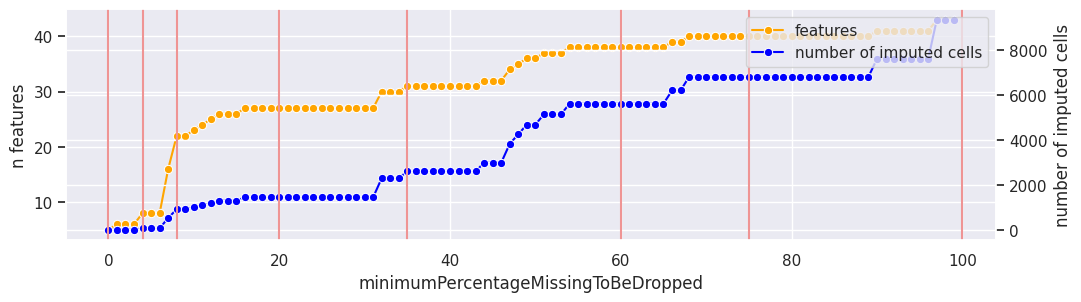

In [149]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="number of imputed cells", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('number of imputed cells')
ax1.figure.legend(['features','number of imputed cells'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)

#add decided thresholds
thresholds = [0,4,8,20,35,60,75,100]
for threshold in thresholds:
    plt.axvline(threshold,color="#ef9494")


plt.show()

In [150]:
percentage_missing = ((df.isna().sum() / len(df) * 100).round(2)).to_dict()
test = {}
for percentage in np.arange(0, 100, 10):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).dropna(axis=0, how='any').shape
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns"]

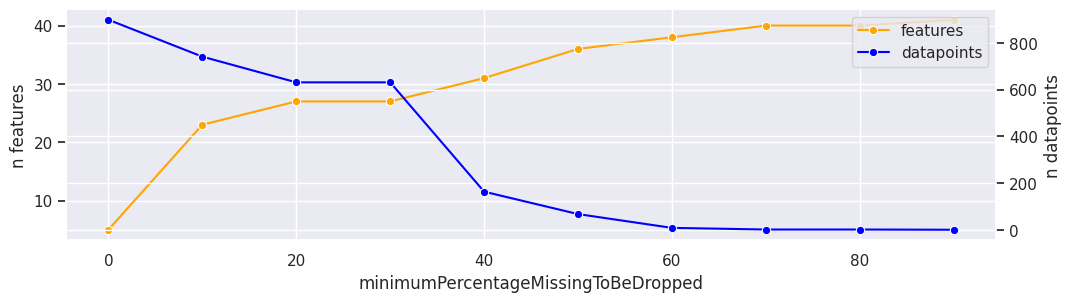

In [151]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="rows", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('n datapoints')
ax1.figure.legend(['features','datapoints'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)
plt.show()

# Model visualisation

In [152]:
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
    def fit(self, X, y=None, **fit_params):
        # there is nothing to be fitted here because this handling is not split specific
        return self

In [153]:
class EnrichHeartData:
    def transform(self, input_df, **transform_params):
        input_df["heart_rate_diff"] = input_df['thalach'] - input_df['thalrest']
        input_df["rldv5_diff"] = input_df['rldv5'] - input_df['rldv5e']
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self

In [154]:
from sklearn.exceptions import NotFittedError


class DropColumnsBasedOnMinimumPercentageToBeDropped:
    def __init__(self):
        self.minimum_percentage_to_be_dropped = 100
        self.fitted = False
        self.valuesToKeep = []

    def set_params(self, **params):
        self.minimum_percentage_to_be_dropped = params.get('minimum_percentage_to_be_dropped')

    def transform(self, input_df, **transform_params):
        if self.fitted:
            return input_df[input_df.columns.intersection(self.valuesToKeep)]
        else:
            raise NotFittedError()

    def fit(self, X, y=None, **fit_params):
        # calculate percentage of missing values for each column and store in a dictionary
        percentage_missing = (X.isna().sum()/len(df)*100).to_dict()
        # generate list of columns to keep
        self.valuesToKeep = [key for key, val in percentage_missing.items() if val <= self.minimum_percentage_to_be_dropped]
        self.fitted = True
        return self

In [155]:
class FixCommonEncodingErrors:
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy(deep=True)
        # if cholesterin is 0 it was not measured
        input_df.loc[input_df['chol'] == 0,'chol'] =  np.float64("NaN")
        # leave the dead ones behind
        # drop entries with a blood pressure of 0
        input_df.loc[input_df['trestbps'] == 0,'trestbps'] =  np.float64("NaN")
        # is a binary variable (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[df['prop'].isin([0,1]) == False,'prop' ] = np.float64("NaN")
        # is a variable that has the values 0-3 by definition  (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[input_df['ca'] >3 ,'ca'] =  np.float64("NaN")
        # transform proto according to possible values from data/ask-detrano
        input_df.loc[input_df['proto'] == 200,'proto'] =  9
        input_df.loc[input_df['proto'] == 175,'proto'] =  8
        input_df.loc[input_df['proto'] == 150,'proto'] =  7
        input_df.loc[input_df['proto'] == 130,'proto'] =  6
        input_df.loc[input_df['proto'] == 125,'proto'] =  5
        input_df.loc[input_df['proto'] == 100,'proto'] = 4
        input_df.loc[input_df['proto'] == 75,'proto'] = 3
        input_df.loc[input_df['proto'] == 50,'proto'] = 2
        input_df.loc[input_df['proto'] == 25,'proto'] = 1
        #set all other values to NaN
        input_df.loc[input_df['proto'].isin([*range(1,13)]) == False, 'proto'] = np.float64("NaN")
        # the timepoint when the measurement was taken can not be larger than the time that the exercise took.
        input_df.loc[df['thaltime'] > df['thaldur'], 'thaltime'] = np.float64('NaN')
        # maximum archived heart rate can not  be lower than the heart rate at rest
        input_df.loc[input_df['thalach'] < input_df['thalrest'],'thalach'] = np.float64('NaN')

        return input_df
    def fit(self, X, y=None, **fit_params):
        return self

In [156]:
df[df["num"]>1] = 1

In [157]:
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('discretize', KBinsDiscretizer(strategy='ordinal'), ['age']),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('fix_encoding_errors', FixCommonEncodingErrors()),
    ('transform_smoke', DataframeSmokeTransformer()),
    ('enrich_heart_rate', EnrichHeartData()),
    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', SimpleImputer()),
    ('scaler', MaxAbsScaler()),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('estimator', DecisionTreeClassifier())
])
parameters = {
    'drop_columns__minimum_percentage_to_be_dropped' : 0,
    'estimator__criterion': "entropy",
    'estimator__max_depth': 6,
    'estimator__min_samples_split': 2,
    'impute__strategy':'mean',
    'oneHotEncoder__discretize': KBinsDiscretizer(5,encode='ordinal', strategy='uniform')
}
pipeline.set_params(**parameters)
pipeline.fit(X,y)

Pipeline(steps=[('fix_encoding_errors',
                 <__main__.FixCommonEncodingErrors object at 0x7facf36011b0>),
                ('transform_smoke',
                 <__main__.DataframeSmokeTransformer object at 0x7facf367b5e0>),
                ('enrich_heart_rate',
                 <__main__.EnrichHeartData object at 0x7facf36789d0>),
                ('drop_columns',
                 <__main__.DropColumnsBasedOnMinimumPercentageToBeDropped object at 0x7facf3532890>),
                ('oneH...
                                   transformers=[('discretize',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'),
                                                  ['age']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <function <lambda> at 0x7facf139d7e0>)])),
                ('impute', SimpleImputer()), ('scaler', MaxAbsScaler()),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('estimator',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6))])

In [158]:
decision_tree = pipeline['estimator']

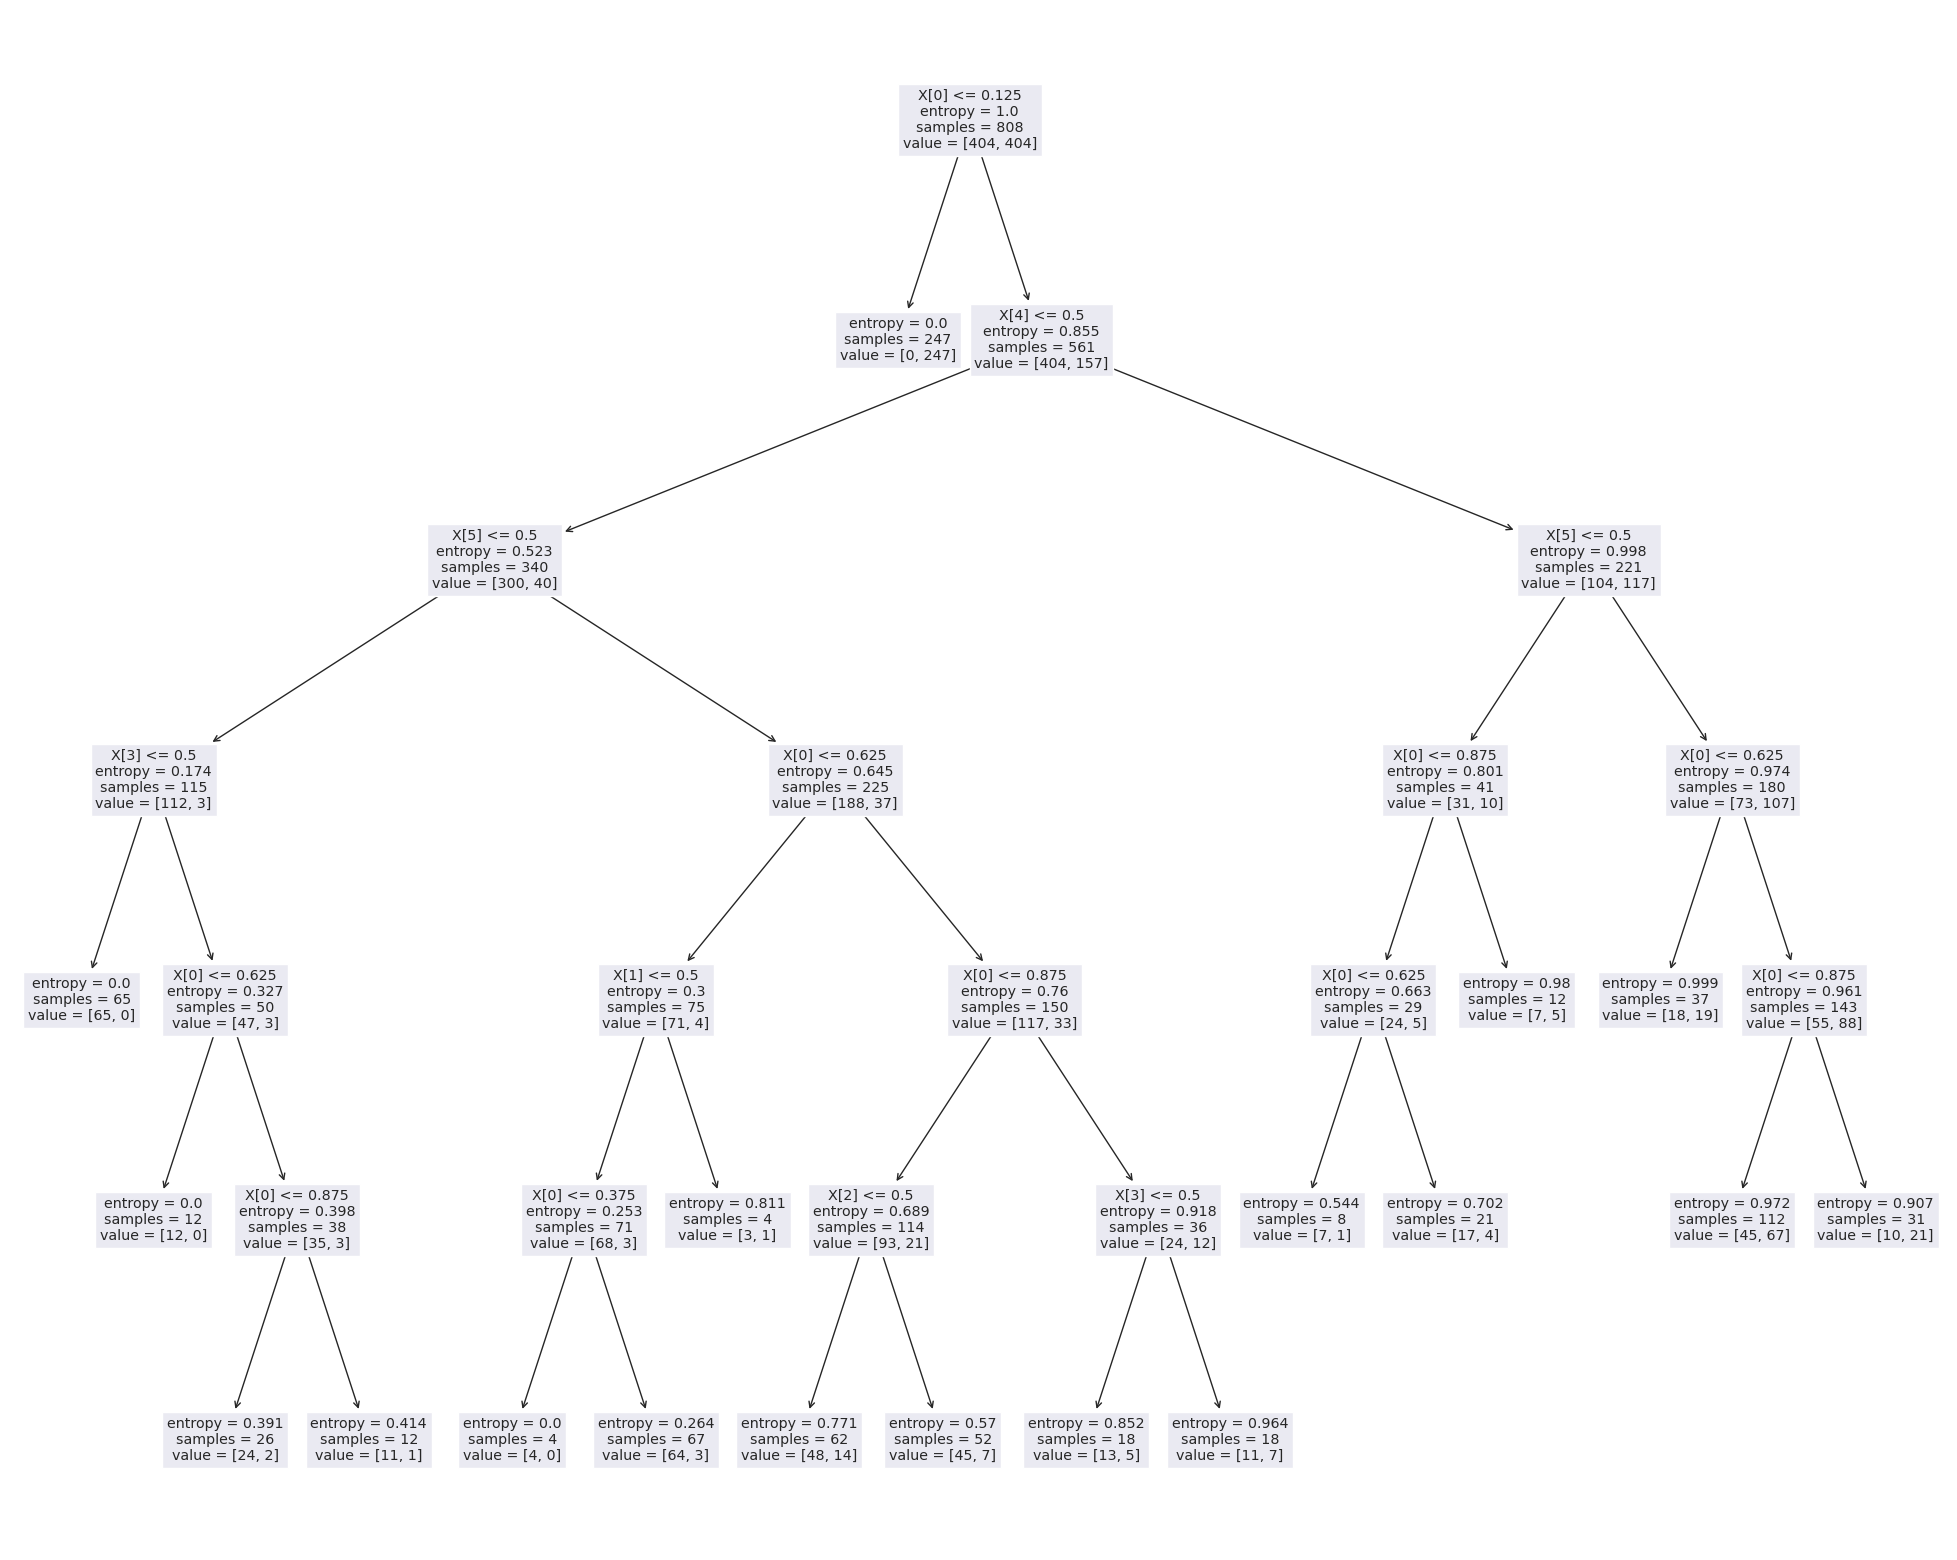

In [159]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree)


In [177]:
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
discretizer =  KBinsDiscretizer(5,encode='ordinal', strategy='uniform')
X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
X_transformed = X_transformed.join(encoded)
imputer = SimpleImputer(strategy='mean')
X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
scaler = MaxAbsScaler()
X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
sampler = RandomUnderSampler(random_state=42)
X_transformed, y = sampler.fit_resample(X_transformed,y)
decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2)
decisionTreeClassifier = decisionTreeClassifier.fit(X_transformed,y)

/home/finn/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/home/finn/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


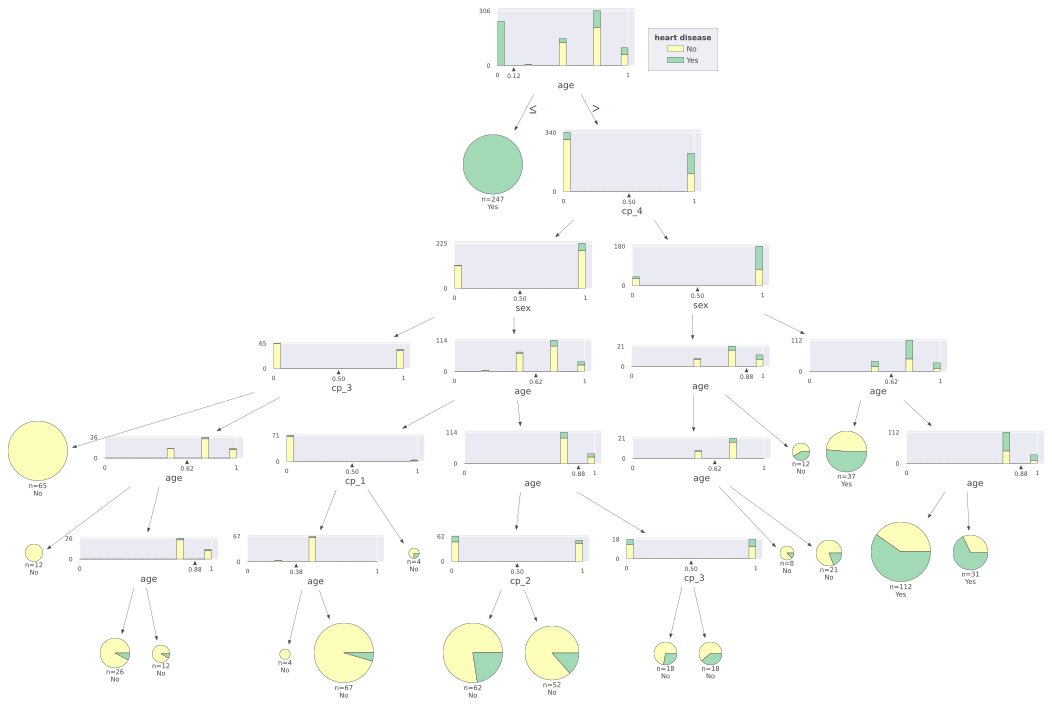

In [178]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(decisionTreeClassifier, X_transformed, y,
               target_name="heart disease",
               feature_names=X_transformed.columns,
               class_names=['No','Yes']
               )

viz
